Training model of type:
Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
  (3): Sigmoid()
)


Crossvalidation fold: 1/4

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.44083908	0.00088772574
		2000	0.19721833	0.00067124795
		3000	0.11358659	0.00044813298
		4000	0.07845536	0.00030133082
		5000	0.061306413	0.00019775129
		6000	0.05232928	0.00012328484
		7000	0.047563672	7.150303e-05
		8000	0.045082644	3.8587874e-05
		9000	0.043809906	2.1087753e-05
		10000	0.043119863	1.1835816e-05
		Final loss:
		10000	0.043119863	1.1835816e-05

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.6177056	0.0001374845
		2000	0.47018254	0.0003134019
		3000	0.39465508	8.872209e-05
		4000	0.37268993	3.638296e-05
		5000	0.36295888	1.8966903e-05
		6000	0.35770512	1.09975035e-05
		7000	0.3545519	6.9766243e-06
		8000	0.35252795	4.6496175e-06
		9000	0.3511502	3.3099416e-06
		10000	0.35011834	2.6387352e-06
		Final loss:
		10000

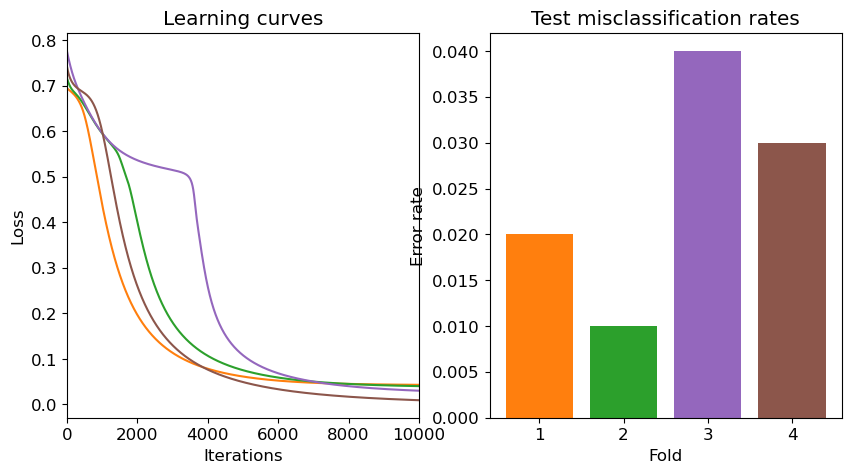

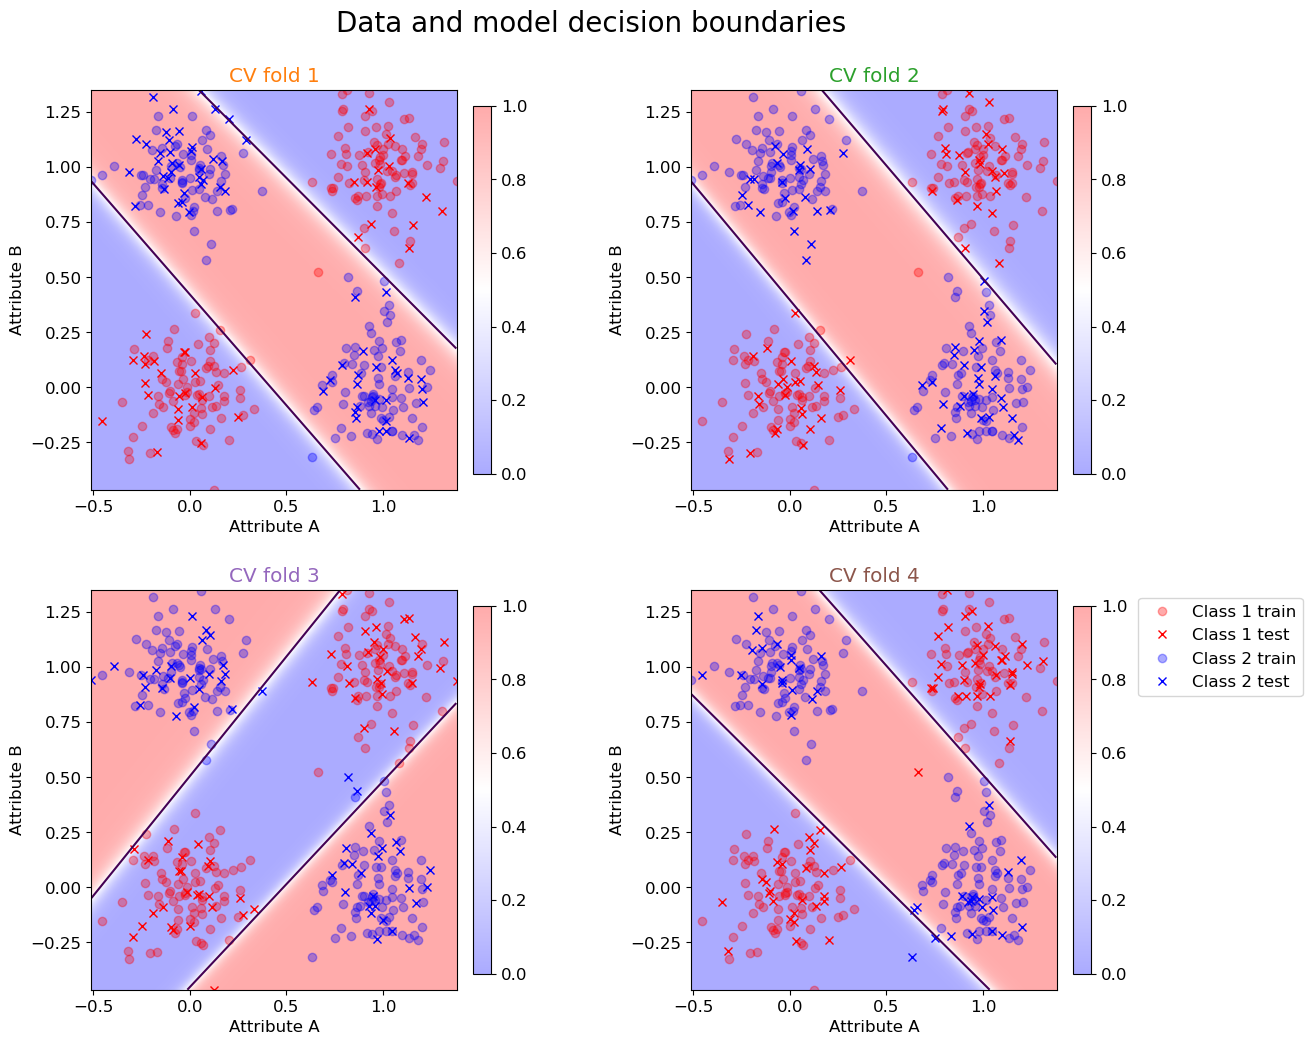

Diagram of best neural net in last fold:


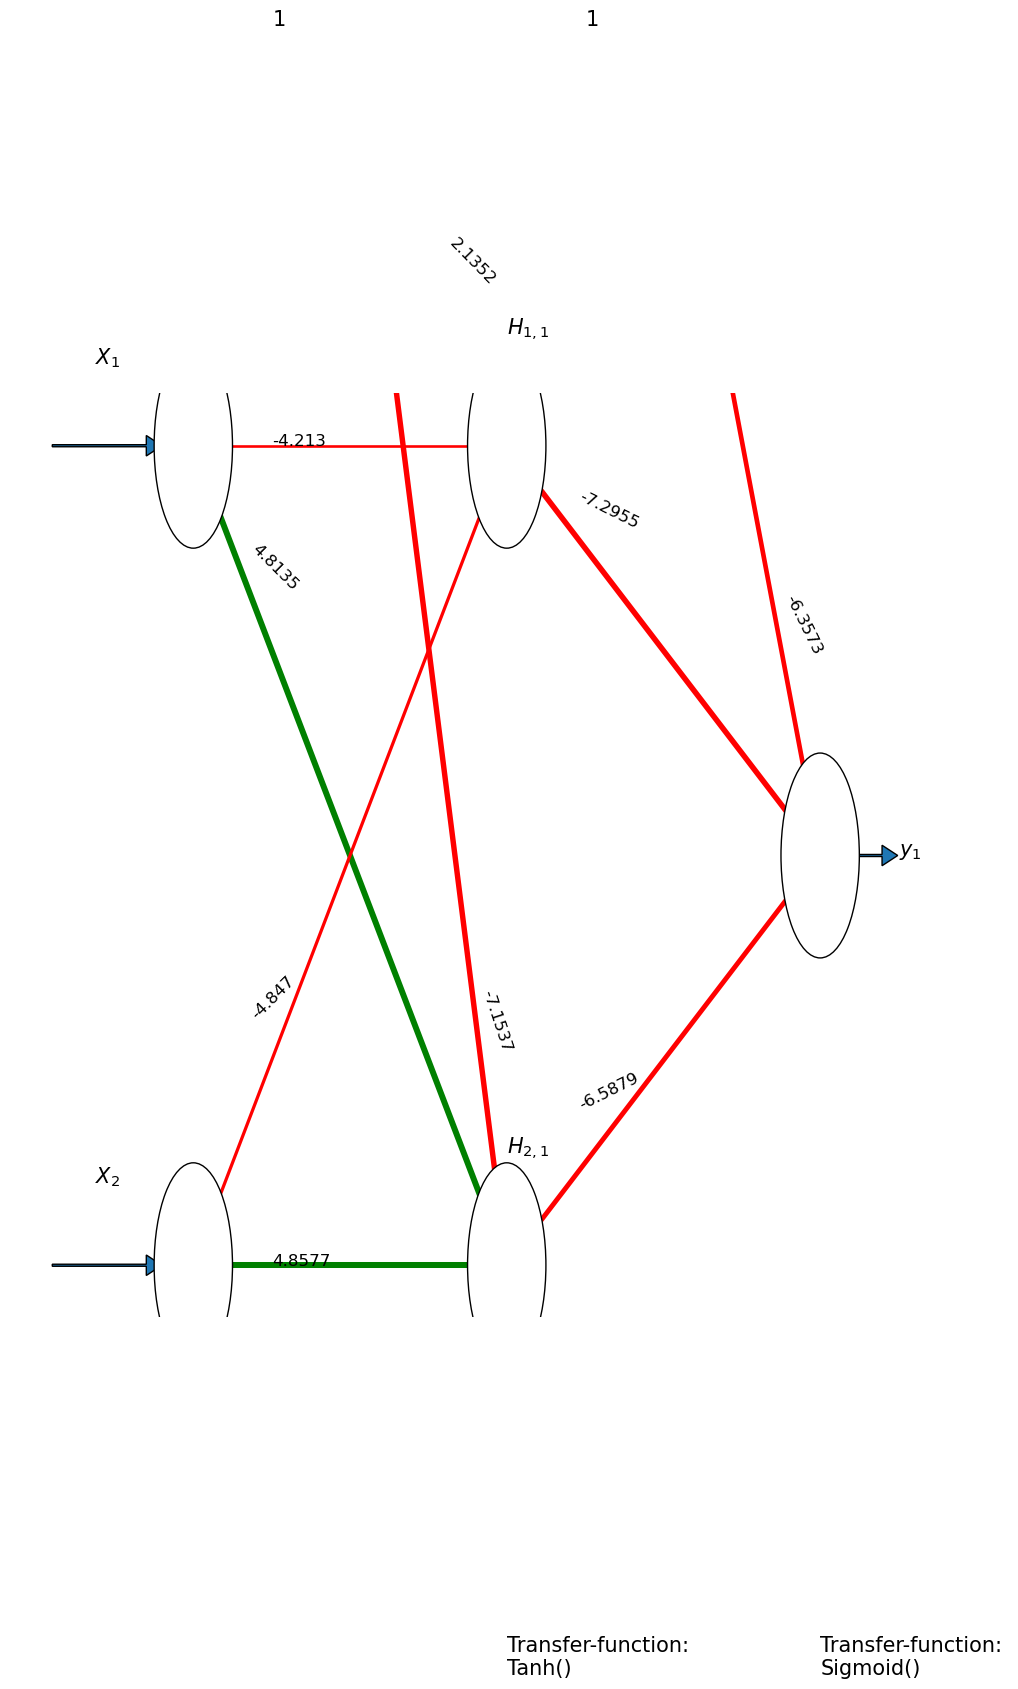


Generalization error/average error rate: 2.5%
Ran exercise 8.2.2.


In [1]:
# exercise 8.2.2
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn import model_selection
from toolbox_02450 import train_neural_net, draw_neural_net, visualize_decision_boundary
import torch
plt.rcParams.update({'font.size': 12})

# read XOR DATA from matlab datafile
mat_data = loadmat('xor.mat')
X = mat_data['X']
y = mat_data['y']

attributeNames = [name[0] for name in mat_data['attributeNames'].squeeze()]
classNames = [name[0] for name in mat_data['classNames'].squeeze()]
N, M = X.shape
C = len(classNames)

# K-fold CrossValidation (4 folds here to speed up this example)
K = 4
CV = model_selection.KFold(K,shuffle=True)

# Setup figure for display of the decision boundary for the several crossvalidation folds.
decision_boundaries = plt.figure(1, figsize=(10,10))
# Determine a size of a plot grid that fits visualizations for the chosen number
# of cross-validation splits, if K=4, this is simply a 2-by-2 grid.
subplot_size_1 = int(np.floor(np.sqrt(K))) 
subplot_size_2 = int(np.ceil(K/subplot_size_1))
# Set overall title for all of the subplots
plt.suptitle('Data and model decision boundaries', fontsize=20)
# Change spacing of subplots
plt.subplots_adjust(left=0, bottom=0, right=1, top=.9, wspace=.5, hspace=0.25)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10,5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']

# Define the model structure
n_hidden_units = 2 # number of hidden units in the signle hidden layer
# The lambda-syntax defines an anonymous function, which is used here to 
# make it easy to make new networks within each cross validation fold
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.Tanh(),                            #torch.nn.ReLU(),
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
# Since we're training a neural network for binary classification, we use a 
# binary cross entropy loss (see the help(train_neural_net) for more on
# the loss_fn input to the function)
loss_fn = torch.nn.BCELoss()
# Train for a maximum of 10000 steps, or until convergence (see help for the 
# function train_neural_net() for more on the tolerance/convergence))
max_iter = 10000
print('Training model of type:\n{}\n'.format(str(model())))

# Do cross-validation:
errors = [] # make a list for storing generalizaition error in each loop
# Loop over each cross-validation split. The CV.split-method returns the 
# indices to be used for training and testing in each split, and calling 
# the enumerate-method with this simply returns this indices along with 
# a counter k:
for k, (train_index, test_index) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, 
    # and convert them to PyTorch tensors
    X_train = torch.Tensor(X[train_index,:] )
    y_train = torch.Tensor(y[train_index] )
    X_test = torch.Tensor(X[test_index,:] )
    y_test = torch.Tensor(y[test_index] )
    
    # Go to the file 'toolbox_02450.py' in the Tools sub-folder of the toolbox
    # and see how the network is trained (search for 'def train_neural_net',
    # which is the place the function below is defined)
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=3,
                                                       max_iter=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_sigmoid = net(X_test) # activation of final note, i.e. prediction of network
    y_test_est = (y_sigmoid > .5).type(dtype=torch.uint8) # threshold output of sigmoidal function
    y_test = y_test.type(dtype=torch.uint8)
    # Determine errors and error rate
    e = (y_test_est != y_test)
    error_rate = (sum(e).type(torch.float)/len(y_test)).data.numpy()
    errors.append(error_rate) # store error rate for current CV fold 
    
    # Make a subplot for current cross validation fold that displays the 
    # decision boundary over the original data, "background color" corresponds
    # to the output of the sigmoidal transfer function (i.e. before threshold),
    # white areas are areas of uncertainty, and a deaper red/blue means 
    # that the network "is more sure" of a given class.
    plt.figure(decision_boundaries.number)
    plt.subplot(subplot_size_1,subplot_size_2,k+1)
    plt.title('CV fold {0}'.format(k+1),color=color_list[k])
    predict = lambda x: net(torch.tensor(x, dtype=torch.float)).data.numpy()
    visualize_decision_boundary(predict, X, y, # provide data, along with function for prediction
                                attributeNames, classNames, # provide information on attribute and class names
                                train=train_index, test=test_index, # provide information on partioning
                                show_legend=k==(K-1)) # only display legend for last plot
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')
    
# Display the error rate across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold');
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('Error rate');
summaries_axes[1].set_title('Test misclassification rates')
    
# Show the plots
# plt.show(decision_boundaries.number) # try these lines if the following code fails (depends on package versions)
# plt.show(summaries.number)
plt.show()

# Display a diagram of the best network in last fold
print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,3]]
draw_neural_net(weights, biases, tf)

# Print the average classification error rate
print('\nGeneralization error/average error rate: {0}%'.format(round(100*np.mean(errors),4)))

print('Ran exercise 8.2.2.')